In [19]:
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import joblib
from train_utils import (
    VAE_EFT,
    compute_errors,
    ROC_curve,
    loss_function,
)

M_Z = 91.1876
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [20]:
# load model and scaler
l = 3
model = VAE_EFT(latent_dim=l).to(device)
model.load_state_dict(torch.load(f"./models/VAE_l_{l}.pth"))
model.eval()
t = joblib.load(f"./models/VAE_l_{3}_scaler.save")

### Load datasets

In [21]:
process = "cW"
sm = pd.read_csv("./data/SM_10k.csv")
o1 = pd.read_csv(f"./data/{process}_1_10k.csv")
o2 = pd.read_csv(f"./data/{process}_2_10k.csv")

selection = [
    "m_ll",
    "m_jj",
    "pt_l1",
    "pt_l2",
    "pt_j1",
    "pt_j2",
    "pt_ll",
    "eta_l1",
    "eta_l2",
    "eta_j1",
    "eta_j2",
    "delta_eta_jj",
    "delta_phi_jj",
]

# Apply cuts
sm = sm[
    (abs(sm["m_ll"] - M_Z) < 15) & (sm["m_jj"] > 300) & (abs(sm["delta_eta_jj"]) > 2.5)
]
o1 = o1[
    (abs(o1["m_ll"] - M_Z) < 15) & (o1["m_jj"] > 300) & (abs(o1["delta_eta_jj"]) > 2.5)
]
o2 = o2[
    (abs(o2["m_ll"] - M_Z) < 15) & (o2["m_jj"] > 300) & (abs(o2["delta_eta_jj"]) > 2.5)
]

# Select variables
sm = sm[selection]
o1 = o1[selection]
o2 = o2[selection]

# Log variables
for vars in ["m_ll", "m_jj", "pt_l1", "pt_l2", "pt_j1", "pt_j2", "pt_ll"]:
    sm[vars] = sm[vars].apply(np.log10)
    o1[vars] = o1[vars].apply(np.log10)
    o2[vars] = o2[vars].apply(np.log10)

# Scale variables
X_sm = t.transform(sm)
X_o1 = t.transform(o1)
X_o2 = t.transform(o2)

In [22]:
# Apply model
model.eval()
T_sm = torch.from_numpy(X_sm).float().to(device)
X_sm_hat, mean, log_var = model.forward(T_sm)
X_sm_hat = X_sm_hat.detach().cpu()

T_o1 = torch.from_numpy(X_o1).float().to(device)
X_o1_hat, mean, log_var = model.forward(T_o1)
X_o1_hat = X_o1_hat.detach().cpu()

T_o2 = torch.from_numpy(X_o2).float().to(device)
X_o2_hat, mean, log_var = model.forward(T_o2)
X_o2_hat = X_o2_hat.detach().cpu()

### Plots

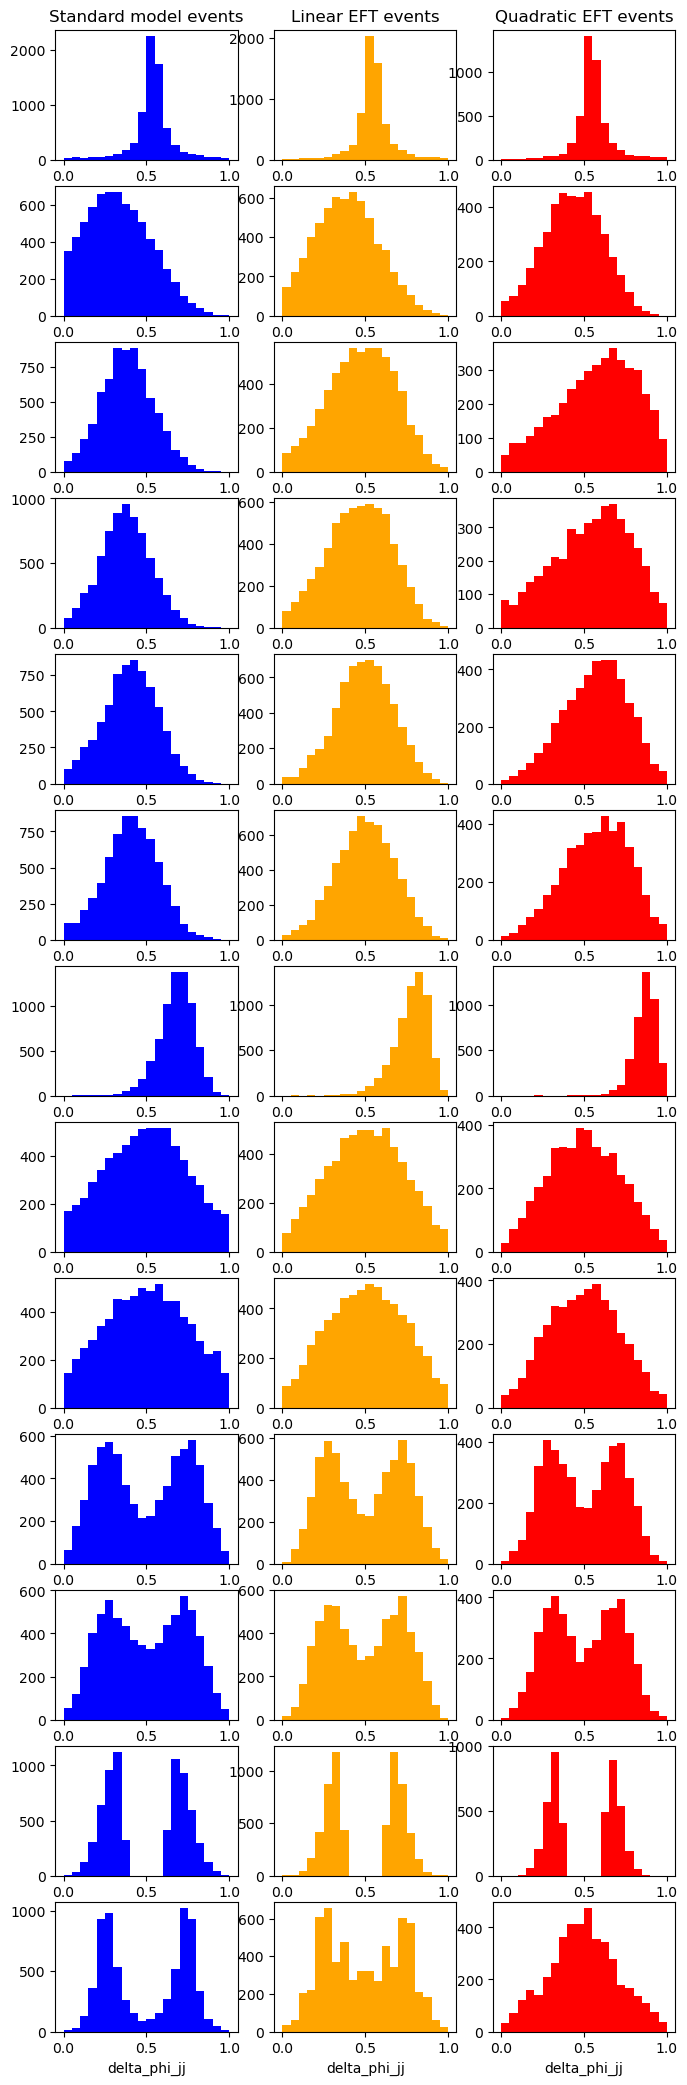

In [23]:
n_bins = 20
n_features = len(selection)
fig, ax = plt.subplots(n_features, 3, figsize=(8, 2 * n_features))
for i in range(n_features):
    ax[i, 0].hist(X_sm[:, i], bins=n_bins, range=(0, 1), color="blue")
    ax[i, 1].hist(X_o1[:, i], bins=n_bins, range=(0, 1), color="orange")
    ax[i, 2].hist(X_o2[:, i], bins=n_bins, range=(0, 1), color="red")
    ax[i, 0].set_xlabel(selection[i])
    ax[i, 1].set_xlabel(selection[i])
    ax[i, 2].set_xlabel(selection[i])
ax[0, 0].set_title("Standard model events")
ax[0, 1].set_title("Linear EFT events")
ax[0, 2].set_title("Quadratic EFT events")
plt.show()

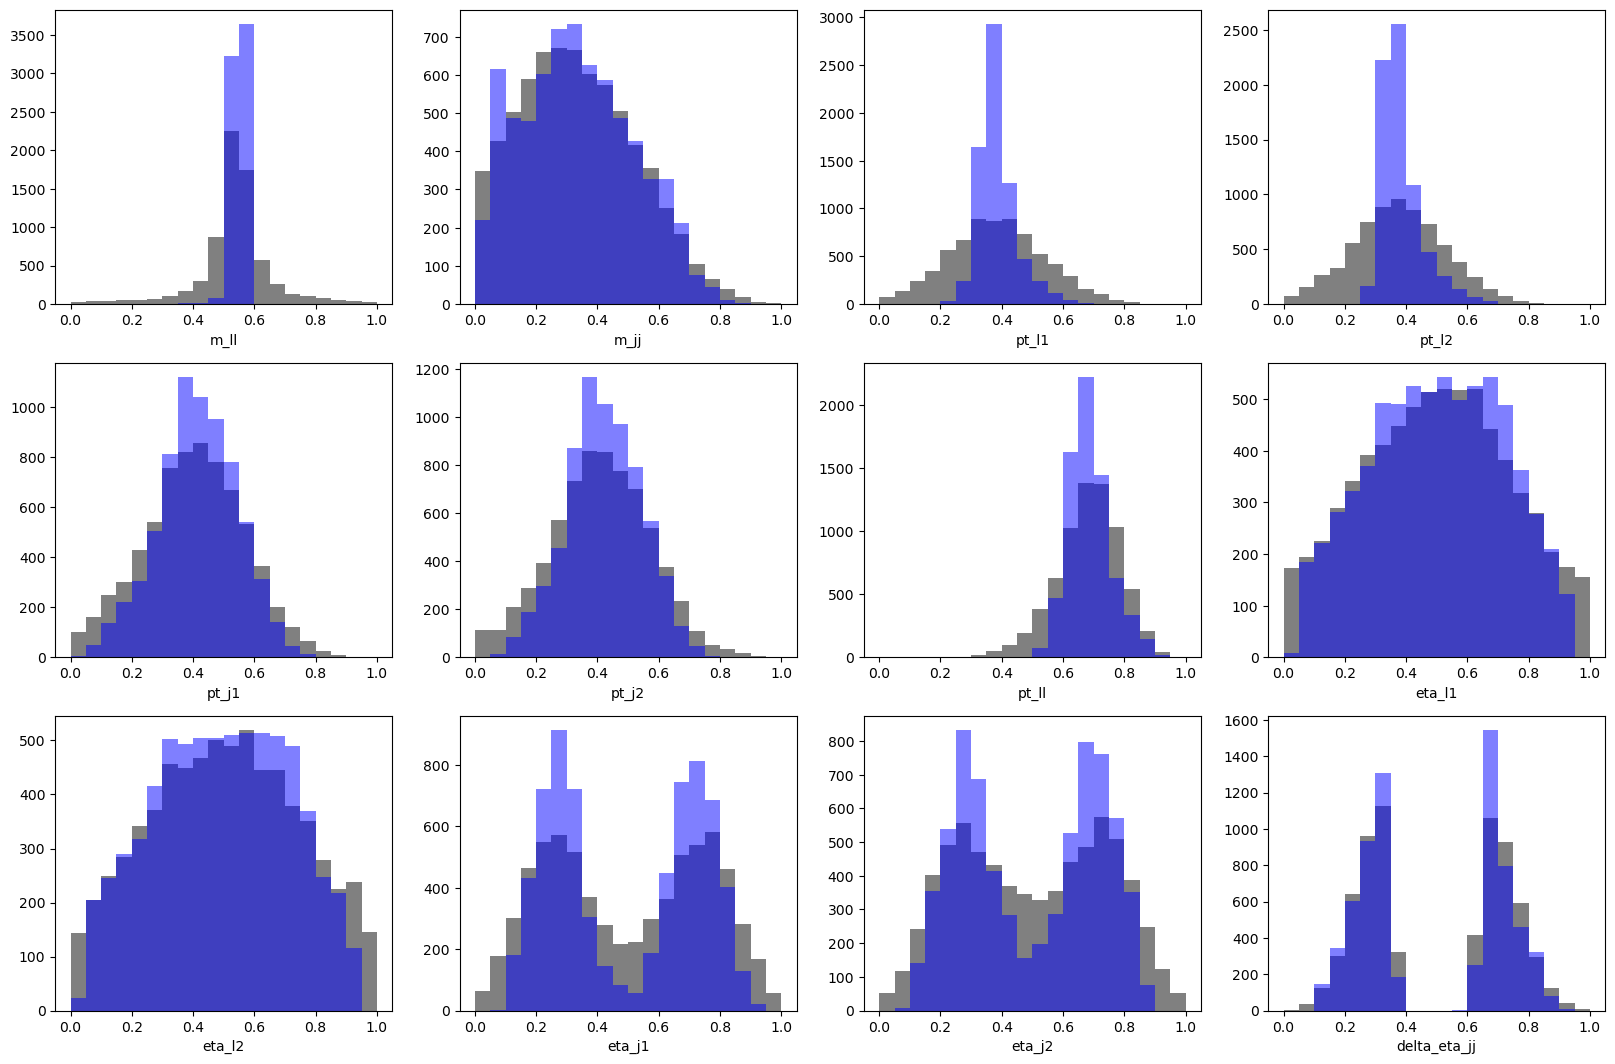

In [24]:
n_bins = 20
n_features = len(selection)
fig, ax = plt.subplots(n_features // 4, 4, figsize=(20, 4 * n_features // 4))
for i in range(n_features // 4):
    ax[i, 0].hist(X_sm[:, 4 * i], bins=n_bins, range=(0, 1), color="grey")
    ax[i, 0].hist(
        X_sm_hat[:, 4 * i], bins=n_bins, range=(0, 1), color="blue", alpha=0.5
    )
    ax[i, 0].set_xlabel(selection[4 * i])

    ax[i, 1].hist(X_sm[:, 4 * i + 1], bins=n_bins, range=(0, 1), color="grey")
    ax[i, 1].hist(
        X_sm_hat[:, 4 * i + 1], bins=n_bins, range=(0, 1), color="blue", alpha=0.5
    )
    ax[i, 1].set_xlabel(selection[4 * i + 1])

    ax[i, 2].hist(X_sm[:, 4 * i + 2], bins=n_bins, range=(0, 1), color="grey")
    ax[i, 2].hist(
        X_sm_hat[:, 4 * i + 2], bins=n_bins, range=(0, 1), color="blue", alpha=0.5
    )
    ax[i, 2].set_xlabel(selection[4 * i + 2])

    ax[i, 3].hist(X_sm[:, 4 * i + 3], bins=n_bins, range=(0, 1), color="grey")
    ax[i, 3].hist(
        X_sm_hat[:, 4 * i + 3], bins=n_bins, range=(0, 1), color="blue", alpha=0.5
    )
    ax[i, 3].set_xlabel(selection[4 * i + 3])
plt.show()

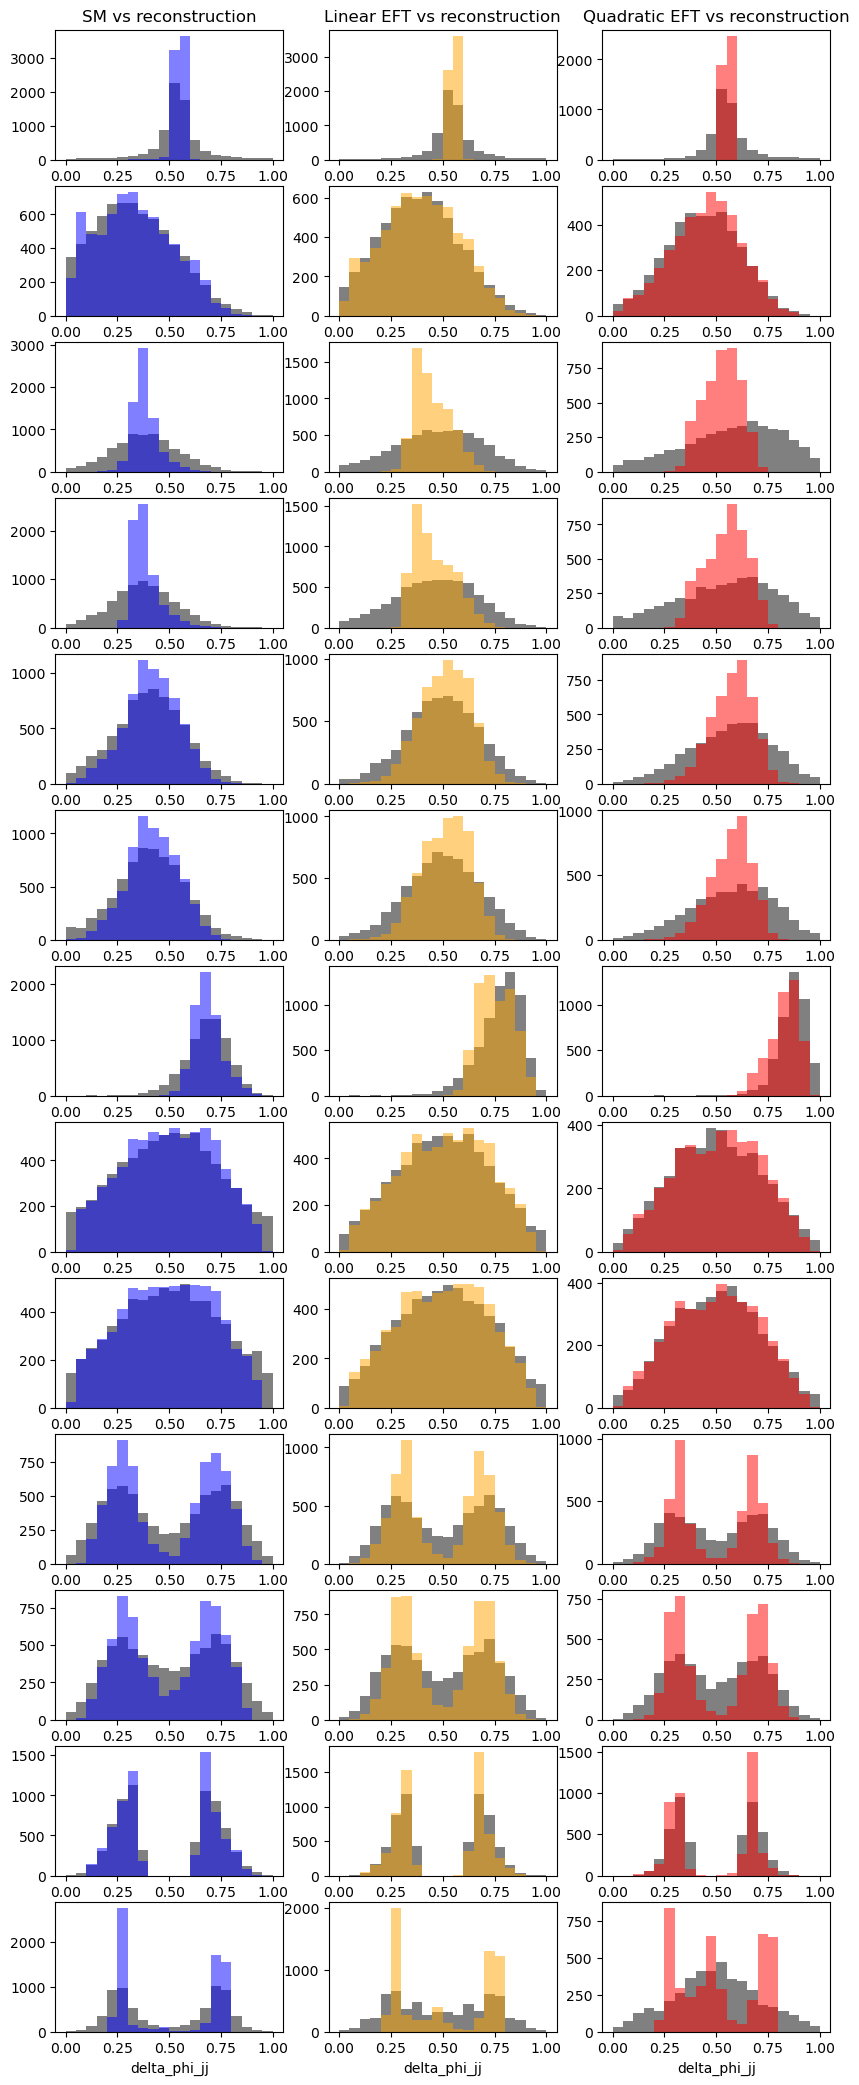

In [25]:
n_bins = 20
n_features = len(selection)
fig, ax = plt.subplots(n_features, 3, figsize=(10, 2 * n_features))
for i in range(n_features):
    ax[i, 0].hist(X_sm[:, i], bins=n_bins, range=(0, 1), color="grey")
    ax[i, 0].hist(X_sm_hat[:, i], bins=n_bins, range=(0, 1), color="blue", alpha=0.5)
    ax[i, 0].set_xlabel(selection[i])

    ax[i, 1].hist(X_o1[:, i], bins=n_bins, range=(0, 1), color="grey")
    ax[i, 1].hist(X_o1_hat[:, i], bins=n_bins, range=(0, 1), color="orange", alpha=0.5)
    ax[i, 1].set_xlabel(selection[i])

    ax[i, 2].hist(X_o2[:, i], bins=n_bins, range=(0, 1), color="grey")
    ax[i, 2].hist(X_o2_hat[:, i], bins=n_bins, range=(0, 1), color="red", alpha=0.5)
    ax[i, 2].set_xlabel(selection[i])

ax[0, 0].set_title("SM vs reconstruction")
ax[0, 1].set_title("Linear EFT vs reconstruction")
ax[0, 2].set_title("Quadratic EFT vs reconstruction")
plt.show()

### Errors

Text(0.5, 1.0, 'ROC curve, AUC = 0.65')

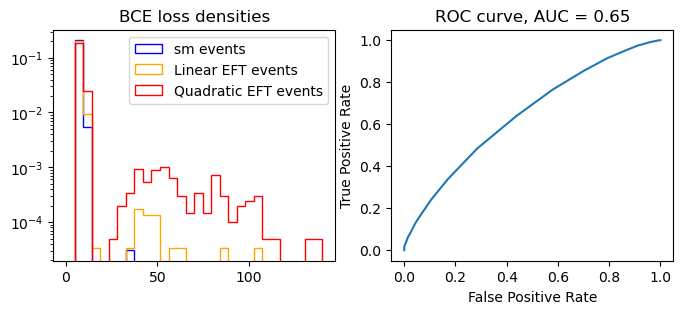

In [26]:
# BCE loss
err_sm_bce = compute_errors(torch.from_numpy(X_sm).float(), X_sm_hat.float())
err_o1_bce = compute_errors(torch.from_numpy(X_o1).float(), X_o1_hat.float())
err_o2_bce = compute_errors(torch.from_numpy(X_o2).float(), X_o2_hat.float())
r__ = (0, max(np.max(err_sm_bce), np.max(err_o1_bce), np.max(err_o2_bce)))

TP, FP, AUC = ROC_curve(err_sm_bce, np.concatenate((err_o1_bce, err_o2_bce)))

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].hist(
    err_sm_bce,
    bins=30,
    range=r__,
    density=True,
    color="blue",
    histtype="step",
    label="sm events",
)
ax[0].hist(
    err_o1_bce,
    bins=30,
    range=r__,
    density=True,
    color="orange",
    histtype="step",
    label="Linear EFT events",
)
ax[0].hist(
    err_o2_bce,
    bins=30,
    range=r__,
    density=True,
    color="red",
    histtype="step",
    label="Quadratic EFT events",
)
ax[0].set_yscale("log")
ax[0].set_title("BCE loss densities")
ax[0].legend()

ax[1].plot(FP, TP)
ax[1].set_xlabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate")
ax[1].set_title(f"ROC curve, AUC = {AUC:.2f}")

Text(0.5, 1.0, 'ROC curve, AUC = 0.63')

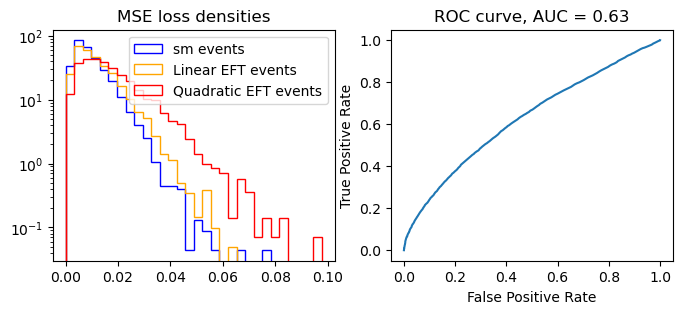

In [28]:
# MSE loss
err_sm_mse = compute_errors(
    torch.from_numpy(X_sm).float(), X_sm_hat.float(), loss_fn="mse"
)
err_o1_mse = compute_errors(
    torch.from_numpy(X_o1).float(), X_o1_hat.float(), loss_fn="mse"
)
err_o2_mse = compute_errors(
    torch.from_numpy(X_o2).float(), X_o2_hat.float(), loss_fn="mse"
)
r__ = (0, max(np.max(err_sm_mse), np.max(err_o1_mse), np.max(err_o2_mse)))

TP, FP, AUC = ROC_curve(err_sm_mse, np.concatenate((err_o1_mse, err_o2_mse)))

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].hist(
    err_sm_mse,
    bins=30,
    range=r__,
    density=True,
    color="blue",
    histtype="step",
    label="sm events",
)
ax[0].hist(
    err_o1_mse,
    bins=30,
    range=r__,
    density=True,
    color="orange",
    histtype="step",
    label="Linear EFT events",
)
ax[0].hist(
    err_o2_mse,
    bins=30,
    range=r__,
    density=True,
    color="red",
    histtype="step",
    label="Quadratic EFT events",
)
ax[0].set_yscale("log")
ax[0].set_title("MSE loss densities")
ax[0].legend()

ax[1].plot(FP, TP)
ax[1].set_xlabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate")
ax[1].set_title(f"ROC curve, AUC = {AUC:.2f}")

/users/eleves-b/2022/baptiste.barthe-gold/.conda/envs/csc_52087/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/tmp/ipykernel_4816/3423866425.py:43: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[0].set_yscale("log")


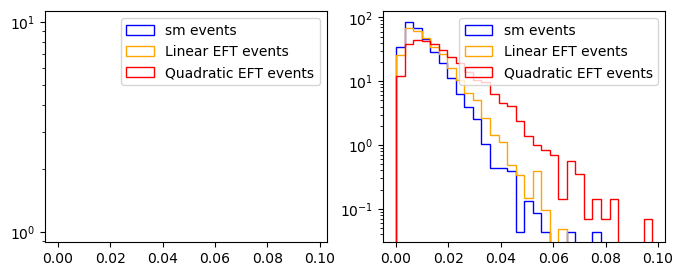

In [30]:
# MSE loss
err_sm_mse = compute_errors(
    torch.from_numpy(X_sm).float(), X_sm_hat.float(), loss_fn="mse"
)
err_o1_mse = compute_errors(
    torch.from_numpy(X_o1).float(), X_o1_hat.float(), loss_fn="mse"
)
err_o2_mse = compute_errors(
    torch.from_numpy(X_o2).float(), X_o2_hat.float(), loss_fn="mse"
)


fig, ax = plt.subplots(1, 2, figsize=(8, 3))
r__ = (0, max(np.max(err_sm_bce), np.max(err_o1_bce), np.max(err_o2_bce)))
ax[0].hist(
    err_sm_bce,
    bins=30,
    range=r__,
    density=True,
    color="blue",
    histtype="step",
    label="sm events",
)
ax[0].hist(
    err_o1_bce,
    bins=30,
    range=r__,
    density=True,
    color="orange",
    histtype="step",
    label="Linear EFT events",
)
ax[0].hist(
    err_o2_bce,
    bins=30,
    range=r__,
    density=True,
    color="red",
    histtype="step",
    label="Quadratic EFT events",
)
ax[0].set_yscale("log")
ax[0].legend()

r__ = (0, max(np.max(err_sm_mse), np.max(err_o1_mse), np.max(err_o2_mse)))
ax[1].hist(
    err_sm_mse,
    bins=30,
    range=r__,
    density=True,
    color="blue",
    histtype="step",
    label="sm events",
)
ax[1].hist(
    err_o1_mse,
    bins=30,
    range=r__,
    density=True,
    color="orange",
    histtype="step",
    label="Linear EFT events",
)
ax[1].hist(
    err_o2_mse,
    bins=30,
    range=r__,
    density=True,
    color="red",
    histtype="step",
    label="Quadratic EFT events",
)
ax[1].set_yscale("log")
ax[1].legend()

### Chi2 Plots

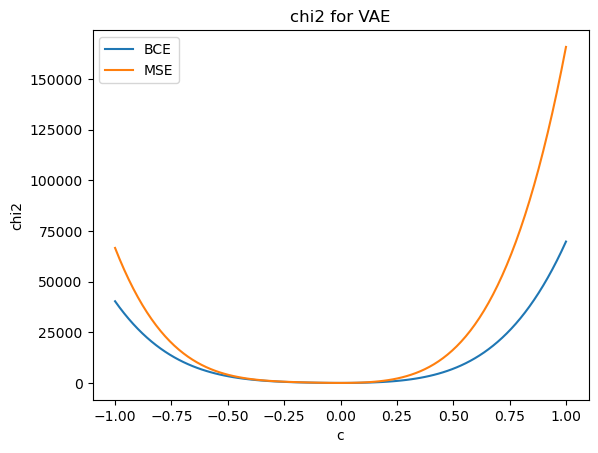

In [29]:
nbins = 200
c = np.linspace(-1, 1, 100)

# BCE
r__ = (0, max(np.max(err_sm_bce), np.max(err_o1_bce), np.max(err_o2_bce)))

sm_h_bce, _ = np.histogram(err_sm_bce, nbins, range=r__)
lin_h_bce, _ = np.histogram(err_o1_bce, nbins, range=r__)
quad_h_bce, _ = np.histogram(err_o2_bce, nbins, range=r__)

eps = 1e-2 * np.min(sm_h_bce[sm_h_bce != 0])
chi_bce = [
    sum(
        (sm_h_bce - (sm_h_bce + (ci) * lin_h_bce + (ci**2) * quad_h_bce)) ** 2
        / (sm_h_bce + eps)
    )
    for ci in c
]

# MSE
r__ = (0, max(np.max(err_sm_mse), np.max(err_o1_mse), np.max(err_o2_mse)))

sm_h_mse, _ = np.histogram(err_sm_mse, nbins, range=r__)
lin_h_mse, _ = np.histogram(err_o1_mse, nbins, range=r__)
quad_h_mse, _ = np.histogram(err_o2_mse, nbins, range=r__)

eps = 1e-2 * np.min(sm_h_mse[sm_h_mse != 0])
chi_mse = [
    sum(
        (sm_h_mse - (sm_h_mse + (ci) * lin_h_mse + (ci**2) * quad_h_mse)) ** 2
        / (sm_h_mse + eps)
    )
    for ci in c
]

plt.plot(c, chi_bce, label="BCE")
plt.plot(c, chi_mse, label="MSE")
plt.xlabel("c")
plt.ylabel("chi2")
plt.title("chi2 for VAE")
plt.legend()